In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")
from tqdm import tqdm

from sklearn.cluster import KMeans


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


In [13]:
data_orig = pd.read_csv('train_contest.csv')


In [14]:
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder

def preposs(data_):
    data = data_.copy()
    data = data.drop(columns=['immediate_redirect_url','response_url','sort_point_distance',\
                              'relations','alternate_url','url','employer','snippet','contacts',\
                              'description','insider_interview','created_at','published_at','department','address'], axis=1)
    data['experience'] = data['experience'].map({x: idx for idx, x in enumerate(data.experience.unique()) })

    def extract_tags(tag_string, col = 'name'):
        import ast
        tags_list = eval(tag_string)
        return [tag[col].lower() if type(tag[col]) is str else tag[col] for tag in tags_list]

    def get_indices(skills, unique_values):
        return [unique_values[skill]  if skill in unique_values else -1 for skill in skills]

    data.key_skills = data.key_skills.apply(extract_tags)
    # key_skills_unique_values = set(data.key_skills.sum())
    # key_skills_unique_dict={x:idx for idx,x in enumerate(key_skills_unique_values)}
    # data['key_skills'] = data['key_skills'].apply(lambda skills: get_indices(skills, key_skills_unique_dict))

    # mlb = MultiLabelBinarizer()
    # key_skills_encoded = mlb.fit_transform(data['key_skills'])
    # key_skills_df = pd.DataFrame(key_skills_encoded, columns=mlb.classes_)
    # data = pd.concat([data, key_skills_df], axis=1)
    data = data.drop(columns=['key_skills'], axis=1)

    data['schedule'] = data['schedule'].map({x: idx for idx, x in enumerate(data.schedule.unique()) })

    data['working_days'] = data['working_days'].map({x: idx for idx, x in enumerate(data.working_days.unique()) })
    data['working_time_intervals'] = data['working_time_intervals'].map({x: idx for idx, x in enumerate(data.working_time_intervals.unique()) })
    data['working_time_modes'] = data['working_time_modes'].map({x: idx for idx, x in enumerate(data.working_time_modes.unique()) })
    data['type'] = data['type'].map({x: idx for idx, x in enumerate(data.type.unique()) })


    data.specializations = data.specializations.apply(lambda x: extract_tags(x,col ='profarea_name'))
    # specializations_unique_values = set(data.specializations.sum())
    # specializations_unique_dict={x:idx for idx,x in enumerate(specializations_unique_values)}
    # data['specializations'] = data['specializations'].apply(lambda skills: set(get_indices(skills, specializations_unique_dict)))

    mlb = MultiLabelBinarizer()
    specializations_encoded = mlb.fit_transform(data['specializations'])
    specializations_df = pd.DataFrame(specializations_encoded, columns=mlb.classes_)
    data = pd.concat([data, specializations_df], axis=1)
    data = data.drop(columns=['specializations'], axis=1)

    # mlb = MultiLabelBinarizer()
    # region_encoded = mlb.fit_transform(data['region'])
    # region_df = pd.DataFrame(region_encoded, columns=mlb.classes_)
    encoder = OneHotEncoder(sparse_output=False)#(sparse_output=False)
    region_encoded = encoder.fit_transform(data[['region']])
    region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['region']))
    data = pd.concat([data, region_df], axis=1)
    data = data.drop(columns=['region'], axis=1)

    data.area = data.area.apply(lambda x: eval(x)['id'])
    # encoder = OneHotEncoder(sparse_output=False)#(sparse_output=False)
    # area_encoded = encoder.fit_transform(data[['area']])
    # area_df = pd.DataFrame(area_encoded, columns=encoder.get_feature_names_out(['area']))
    # data = pd.concat([data, area_df], axis=1)
    # data = data.drop(columns=['area'], axis=1)

    data['name'] = data['name'].map({x: idx for idx, x in enumerate(data.name.unique()) })
    return data

In [102]:
data = preposs(data_orig)

In [6]:
class_drop = ['premium', 'department', 'has_test', 'response_letter_required',
                     'working_days', 'working_time_intervals', 'working_time_modes',
                     'immediate_redirect_url', 'published_at', 'created_at',
                     'response_url', 'sort_point_distance', 'archived', 'insider_interview',
                    'url', 'alternate_url', 'relations', 'type', 'address',
                    'accept_temporary']
data_orig.drop(columns = class_drop,
         inplace = True)

In [9]:
import json
import re

data = data_orig.copy()

In [10]:
def get_emp(x):
    res = re.findall(r"'name': [\"']([^']+)[\"']", x)
    if res == []:
        print(x)
    return res[0]

def get_name(x):
    return json.loads(x.replace("'", '"'))['name']

def get_reg(x):
    res = re.findall(r"'requirement': [\"']([^']+)[\"']", x)
    if res == []:
        return ''
    return res[0]

def get_resp(x):
    res = re.findall(r"'responsibility': [\"']([^']+)[\"']", x)
    if res == []:
        return ''
    return res[0]

def data_process(data):
    data['type_schedule'] = data['schedule'].apply(get_name)

    data['city'] = data['area'].apply(get_name)

    data['name_employer'] = data['employer'].apply(get_emp)

    data['has_contacts'] = data['contacts'].isna()
    data['has_contacts'] = data['has_contacts'].replace({True: 1, False: 0})


    data['exp'] = data['experience'].apply(get_name)
    
    data['reg'] =  data['snippet'].apply(get_reg)
    data['resp'] = data['snippet'].apply(get_resp)
    
    return data

In [10]:
data = data_process(data)

NameError: name 'data_process' is not defined

In [42]:
col_to_drop1 = ['schedule', 
              'area',
              'employer',
              'contacts',
              'experience']

data.drop(columns = col_to_drop1,
         inplace = True)

KeyError: "['schedule', 'area', 'employer', 'contacts', 'experience'] not found in axis"

In [15]:
import ast
from tqdm import tqdm

def extract_skills(skill_str):
    # Преобразуем строку в список словарей
    skills_list = ast.literal_eval(skill_str)
    # Извлекаем все значения 'name' из списка
    return [skill['name'] for skill in skills_list]

# Применяем функцию для каждого элемента в столбце "skills"
data['skills'] = data['key_skills'].apply(extract_skills)

# Извлекаем все уникальные навыки из всех записей
all_skills = set([skill for sublist in data['skills'] for skill in sublist])

# Создаем новые столбцы для каждого навыка
for skill in tqdm(all_skills):
    data[skill] = data['skills'].apply(lambda x: 1 if skill in x else 0)

100%|██████████| 7779/7779 [03:02<00:00, 42.64it/s]


In [14]:
import ast
from tqdm import tqdm

def extract_skills(skill_str):
    # Преобразуем строку в список словарей
    skills_list = ast.literal_eval(skill_str)
    # Извлекаем все значения 'name' из списка
    return [skill['name'] for skill in skills_list]

# Применяем функцию для каждого элемента в столбце "skills"
data['skills'] = data['specializations'].apply(extract_skills)

# Извлекаем все уникальные навыки из всех записей
all_skills = set([skill for sublist in data['skills'] for skill in sublist])

# Создаем новые столбцы для каждого навыка
for skill in tqdm(all_skills):
    data[skill] = data['skills'].apply(lambda x: 1 if skill in x else 0)

100%|██████████| 255/255 [00:05<00:00, 47.45it/s]


In [16]:
data_skills = data.copy()


In [44]:
col_to_drop2 = ['key_skills', 
                'skills',
               'snippet', 'specializations',
                'resp', 'reg',
              'description']

data.drop(columns = col_to_drop2,
         inplace = True)

KeyError: "['key_skills', 'skills', 'snippet', 'specializations', 'resp', 'reg', 'description'] not found in axis"

In [19]:
from huggingface_hub import hf_hub_download
import fasttext

model_emb = fasttext.load_model(hf_hub_download("facebook/fasttext-ru-vectors", "model.bin"))

def emb(x):
    return model[x]

f = data_orig['description'].apply(lambda x: model_emb[x])

t = pd.DataFrame(f)

# Преобразуем каждое значение списка в отдельный столбец
df = t['description'].apply(pd.Series)

# Опционально, переименовать столбцы, если необходимо
df.columns = [f'feature_{i+1}' for i in range(df.shape[1])]

# Вывод результата


In [180]:
data = preposs(data_orig)

In [181]:
y = data["mean_salary"]
X = data.drop(columns=["mean_salary"])

In [182]:
for column in df.iloc[X.index].columns:
    X[column] = df[column]

In [183]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

<Axes: xlabel='mean_salary', ylabel='Density'>

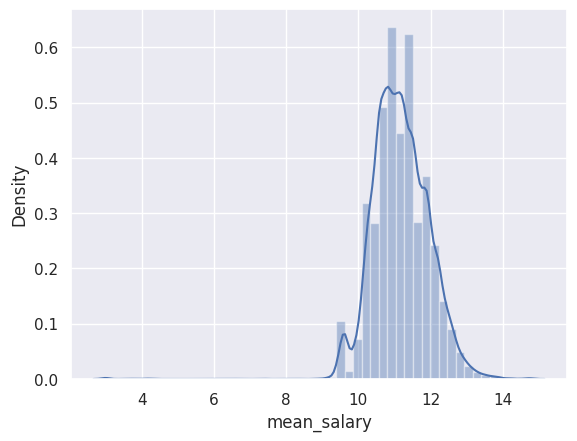

In [184]:
sns.distplot(np.log(y_train))

In [187]:
from catboost import CatBoostRegressor

model = CatBoostRegressor( iterations = 1000,
                            l2_leaf_reg=10,
                          cat_features = list(X_train.select_dtypes('object').columns) )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

0:	learn: 104794.1564698	total: 17.2ms	remaining: 17.2s
1:	learn: 104018.5639303	total: 32.5ms	remaining: 16.2s
2:	learn: 103350.3736434	total: 46.6ms	remaining: 15.5s
3:	learn: 102737.8058959	total: 60.2ms	remaining: 15s
4:	learn: 102089.9194998	total: 74.4ms	remaining: 14.8s
5:	learn: 101456.3991861	total: 89.8ms	remaining: 14.9s
6:	learn: 100881.5479102	total: 104ms	remaining: 14.8s
7:	learn: 100189.1524896	total: 118ms	remaining: 14.6s
8:	learn: 99481.0545472	total: 132ms	remaining: 14.5s
9:	learn: 98945.9404315	total: 147ms	remaining: 14.5s
10:	learn: 98323.0758596	total: 158ms	remaining: 14.2s
11:	learn: 97697.3494041	total: 171ms	remaining: 14.1s
12:	learn: 97118.2672505	total: 185ms	remaining: 14.1s
13:	learn: 96560.6670880	total: 196ms	remaining: 13.8s
14:	learn: 96008.9936003	total: 208ms	remaining: 13.7s
15:	learn: 95544.1261800	total: 223ms	remaining: 13.7s
16:	learn: 95022.6382833	total: 237ms	remaining: 13.7s
17:	learn: 94546.8557652	total: 250ms	remaining: 13.6s
18:	lear

155:	learn: 74110.7096716	total: 2.28s	remaining: 12.3s
156:	learn: 74061.2471814	total: 2.29s	remaining: 12.3s
157:	learn: 74012.5572741	total: 2.31s	remaining: 12.3s
158:	learn: 73960.0441197	total: 2.33s	remaining: 12.3s
159:	learn: 73879.2806918	total: 2.34s	remaining: 12.3s
160:	learn: 73826.4315504	total: 2.36s	remaining: 12.3s
161:	learn: 73734.4762355	total: 2.37s	remaining: 12.3s
162:	learn: 73680.5364556	total: 2.4s	remaining: 12.3s
163:	learn: 73642.8236151	total: 2.41s	remaining: 12.3s
164:	learn: 73607.9533008	total: 2.42s	remaining: 12.3s
165:	learn: 73494.0603299	total: 2.44s	remaining: 12.2s
166:	learn: 73410.3978584	total: 2.45s	remaining: 12.2s
167:	learn: 73337.1386659	total: 2.47s	remaining: 12.2s
168:	learn: 73284.2149200	total: 2.48s	remaining: 12.2s
169:	learn: 73224.0651542	total: 2.5s	remaining: 12.2s
170:	learn: 73191.2635035	total: 2.51s	remaining: 12.2s
171:	learn: 73144.7053206	total: 2.52s	remaining: 12.2s
172:	learn: 73106.5234305	total: 2.54s	remaining: 

306:	learn: 67606.5262993	total: 4.54s	remaining: 10.2s
307:	learn: 67573.5999053	total: 4.55s	remaining: 10.2s
308:	learn: 67526.3983640	total: 4.57s	remaining: 10.2s
309:	learn: 67494.2231439	total: 4.58s	remaining: 10.2s
310:	learn: 67463.2204741	total: 4.59s	remaining: 10.2s
311:	learn: 67425.6631599	total: 4.61s	remaining: 10.2s
312:	learn: 67407.0135605	total: 4.62s	remaining: 10.1s
313:	learn: 67369.6842772	total: 4.64s	remaining: 10.1s
314:	learn: 67350.8264436	total: 4.65s	remaining: 10.1s
315:	learn: 67327.1523634	total: 4.66s	remaining: 10.1s
316:	learn: 67299.0556461	total: 4.68s	remaining: 10.1s
317:	learn: 67260.3572385	total: 4.7s	remaining: 10.1s
318:	learn: 67222.5100314	total: 4.71s	remaining: 10.1s
319:	learn: 67203.3455504	total: 4.72s	remaining: 10s
320:	learn: 67170.8043311	total: 4.74s	remaining: 10s
321:	learn: 67096.4334973	total: 4.77s	remaining: 10s
322:	learn: 67057.5319285	total: 4.78s	remaining: 10s
323:	learn: 67049.0220313	total: 4.79s	remaining: 10s
324

459:	learn: 63315.2532045	total: 6.8s	remaining: 7.98s
460:	learn: 63293.5334872	total: 6.81s	remaining: 7.96s
461:	learn: 63287.3331448	total: 6.82s	remaining: 7.95s
462:	learn: 63223.0902332	total: 6.84s	remaining: 7.93s
463:	learn: 63203.1922177	total: 6.85s	remaining: 7.92s
464:	learn: 63187.1246248	total: 6.87s	remaining: 7.9s
465:	learn: 63171.2997813	total: 6.88s	remaining: 7.89s
466:	learn: 63154.5924639	total: 6.9s	remaining: 7.88s
467:	learn: 63122.3942901	total: 6.92s	remaining: 7.86s
468:	learn: 63090.6106081	total: 6.93s	remaining: 7.85s
469:	learn: 63065.2796131	total: 6.95s	remaining: 7.83s
470:	learn: 63051.8531158	total: 6.96s	remaining: 7.82s
471:	learn: 63029.1391829	total: 6.97s	remaining: 7.8s
472:	learn: 63012.5797192	total: 6.99s	remaining: 7.78s
473:	learn: 62998.2581141	total: 7s	remaining: 7.77s
474:	learn: 62985.1171950	total: 7.01s	remaining: 7.75s
475:	learn: 62938.0122834	total: 7.03s	remaining: 7.74s
476:	learn: 62920.8557305	total: 7.04s	remaining: 7.72s

613:	learn: 59607.8030878	total: 9.04s	remaining: 5.68s
614:	learn: 59587.0650114	total: 9.06s	remaining: 5.67s
615:	learn: 59569.2403864	total: 9.07s	remaining: 5.65s
616:	learn: 59560.8757154	total: 9.09s	remaining: 5.64s
617:	learn: 59538.7239114	total: 9.1s	remaining: 5.62s
618:	learn: 59519.9469846	total: 9.11s	remaining: 5.61s
619:	learn: 59507.1890908	total: 9.13s	remaining: 5.59s
620:	learn: 59476.0656389	total: 9.14s	remaining: 5.58s
621:	learn: 59446.4653301	total: 9.15s	remaining: 5.56s
622:	learn: 59436.1036913	total: 9.17s	remaining: 5.55s
623:	learn: 59393.6391104	total: 9.18s	remaining: 5.53s
624:	learn: 59366.4018141	total: 9.2s	remaining: 5.52s
625:	learn: 59353.1546953	total: 9.21s	remaining: 5.5s
626:	learn: 59338.9278038	total: 9.23s	remaining: 5.49s
627:	learn: 59327.9315376	total: 9.24s	remaining: 5.47s
628:	learn: 59306.9536247	total: 9.26s	remaining: 5.46s
629:	learn: 59299.0410062	total: 9.27s	remaining: 5.44s
630:	learn: 59275.2264197	total: 9.29s	remaining: 5

768:	learn: 56729.9191645	total: 11.3s	remaining: 3.39s
769:	learn: 56719.6107001	total: 11.3s	remaining: 3.37s
770:	learn: 56697.2316028	total: 11.3s	remaining: 3.36s
771:	learn: 56687.3366480	total: 11.3s	remaining: 3.34s
772:	learn: 56679.4549544	total: 11.3s	remaining: 3.33s
773:	learn: 56665.2438347	total: 11.3s	remaining: 3.31s
774:	learn: 56633.2667960	total: 11.4s	remaining: 3.3s
775:	learn: 56614.4647327	total: 11.4s	remaining: 3.28s
776:	learn: 56601.4857681	total: 11.4s	remaining: 3.27s
777:	learn: 56593.6028842	total: 11.4s	remaining: 3.25s
778:	learn: 56565.6792151	total: 11.4s	remaining: 3.24s
779:	learn: 56557.3483603	total: 11.4s	remaining: 3.22s
780:	learn: 56545.7681793	total: 11.4s	remaining: 3.21s
781:	learn: 56523.9217269	total: 11.5s	remaining: 3.19s
782:	learn: 56507.1797598	total: 11.5s	remaining: 3.18s
783:	learn: 56488.2396813	total: 11.5s	remaining: 3.16s
784:	learn: 56466.1643846	total: 11.5s	remaining: 3.15s
785:	learn: 56445.5961278	total: 11.5s	remaining:

924:	learn: 54105.1403486	total: 13.5s	remaining: 1.1s
925:	learn: 54086.0772760	total: 13.5s	remaining: 1.08s
926:	learn: 54065.7735537	total: 13.6s	remaining: 1.07s
927:	learn: 54059.2825754	total: 13.6s	remaining: 1.05s
928:	learn: 54038.5802994	total: 13.6s	remaining: 1.04s
929:	learn: 54032.5776415	total: 13.6s	remaining: 1.02s
930:	learn: 54008.6913757	total: 13.6s	remaining: 1.01s
931:	learn: 53989.1953202	total: 13.6s	remaining: 994ms
932:	learn: 53981.4773528	total: 13.6s	remaining: 979ms
933:	learn: 53954.1499342	total: 13.7s	remaining: 965ms
934:	learn: 53944.3874091	total: 13.7s	remaining: 950ms
935:	learn: 53931.1819327	total: 13.7s	remaining: 936ms
936:	learn: 53916.3728176	total: 13.7s	remaining: 921ms
937:	learn: 53894.9552515	total: 13.7s	remaining: 906ms
938:	learn: 53881.0211164	total: 13.7s	remaining: 892ms
939:	learn: 53866.6996706	total: 13.7s	remaining: 877ms
940:	learn: 53846.1920101	total: 13.8s	remaining: 863ms
941:	learn: 53837.7402527	total: 13.8s	remaining:

In [188]:
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print('Test R2 = %.4f' % r2_score(y_test, y_pred) )
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
print('Train R2 = %.4f' % r2_score(y_train, y_train_pred) )
print('Train MAE = %.4f' % mean_absolute_error(X_train, y_train) )
print('Test MAE = %.4f' % mean_absolute_error(X_test, y_test) )

Test RMSE = 64998.6268
Test R2 = 0.6026
Train RMSE = 52701.5676
Train R2 = 0.7509


NameError: name 'mean_absolute_error' is not defined

In [189]:
from catboost import Pool
cat_pool = Pool(X_train,
               cat_features = list(X_train.select_dtypes('object').columns))

In [190]:
d = pd.DataFrame({'feature_importance': model.get_feature_importance(data = cat_pool), 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
d

,feature_importance,feature_names
4,12.622970,area
12,11.463646,experience
63,11.051232,region_Краснодарский край
36,5.875872,"строительство, недвижимость"
26,2.716577,консультирование
...,...,...
75,0.000000,region_Новосибирская область
74,0.000000,region_Новгородская область
73,0.000000,region_Нижегородская область
67,0.000000,region_Ленинградская область


In [191]:
dc = list(set([a.split('_')[0] if 'feature' not in a else a for a in top_100_feat['feature_names'] ]))

In [192]:
top_feat = d.loc[d['feature_importance'] != 0].iloc[:300]
top_feat

,feature_importance,feature_names
4,12.622970,area
12,11.463646,experience
63,11.051232,region_Краснодарский край
36,5.875872,"строительство, недвижимость"
26,2.716577,консультирование
...,...,...
165,0.012006,feature_43
224,0.011526,feature_102
255,0.011112,feature_133
173,0.010659,feature_51


In [193]:
example = pd.read_csv('Sample_Submission.csv')
test_orig = pd.read_csv('for_prediction.csv')

In [194]:
test = test_orig.copy()

In [195]:
test.drop(columns = ['Id'],
         inplace = True)

In [196]:
test = preposs(test)

In [73]:
from huggingface_hub import hf_hub_download
import fasttext

model_emb = fasttext.load_model(hf_hub_download("facebook/fasttext-ru-vectors", "model.bin"))

f_test = test_orig['description'].apply(lambda x: model_emb[x])

t_test = pd.DataFrame(f_test)

# Преобразуем каждое значение списка в отдельный столбец
df_test = t_test['description'].apply(pd.Series)

# Опционально, переименовать столбцы, если необходимо
df_test.columns = [f'feature_{i+1}' for i in range(df_test.shape[1])]

# Вывод результата


In [197]:
for column in df_test.iloc[test.index].columns:
    test[column] = df_test[column]

In [200]:
test = test[X_train.columns]

In [ ]:
# def extract_skills(skill_str):
#     # Преобразуем строку в список словарей
#     skills_list = ast.literal_eval(skill_str)
#     # Извлекаем все значения 'name' из списка
#     return [skill['name'] for skill in skills_list]

# # Применяем функцию для каждого элемента в столбце "skills"
# test['skills'] = test['key_skills'].apply(extract_skills)

# # Извлекаем все уникальные навыки из всех записей
# all_skills = set([skill for sublist in test['skills'] for skill in sublist])

# # Создаем новые столбцы для каждого навыка
# for skill in tqdm(all_skills):
#     test[skill] = test['skills'].apply(lambda x: 1 if skill in x else 0)

In [75]:
test_skills = test.copy()

In [76]:
# test.drop(columns = col_to_drop1,
#          inplace = True)

# # test.drop(columns = col_to_drop2,
#          inplace = True)

In [199]:
for col in tqdm(X_train.columns):
    if col not in test:
        test[col] = X_train[col].mean()

100%|██████████| 423/423 [00:00<00:00, 153889.37it/s]


In [150]:
# for col in tqdm(test.columns):
#     if col not in X_train:
#          X_train[col] = 0

100%|██████████| 434/434 [00:00<00:00, 211150.44it/s]


In [201]:
predss = model.predict(test)

In [202]:
example['Predicted'] = predss

In [203]:
example.to_csv('predictions.csv', index = False)